#  Classical-quantum Neural Network for binary classification

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.feature_extraction.text import CountVectorizer

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os, random, json, math
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import re

import qiskit
from qiskit import transpile
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from qiskit.circuit.library import NLocal
from qiskit.circuit import QuantumCircuit, ClassicalRegister, ParameterVector
from qiskit.transpiler.passes import RemoveBarriers
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN

## Data loading

In [ ]:
num_classes = 2
trapart = 0.8
val_part = 0.5 # from 1 - train_part

# hyper parameters
train_flag = False
epochs=30
initial_lr = 0.00025
w_decay = 0.0001
q_reps = 3

In [ ]:
dataset_path = 'Dataset/'
dataset_name_train = 'task-3-dataset.csv'
dataset_name = 'test50.csv'
df = pd.read_csv(dataset_path+dataset_name)
df_tr = pd.read_csv(dataset_path+dataset_name_train)
df_train_size = len(df_tr)
df = pd.concat([df_tr, df])
text = list(df['отзывы'])

In [5]:
lemmatize = nltk.WordNetLemmatizer()
stop_words = set(stopwords.words('russian'))
new_text = []
for i in df['отзывы']:
    text_ = re.sub("[^a-zA-Zа-яА-Я1-9]"," ",str(i))
    text_ = nltk.word_tokenize(text_, language='russian')
    text_ = [word for word in text_ if word not in stop_words]
    text_ = [lemmatize.lemmatize(word) for word in text_]
    text_ = " ".join(text_)
    new_text.append(text_)

In [6]:
count = CountVectorizer(stop_words="english")
matrix = count.fit_transform(new_text).toarray()
max_len = len(matrix[0])
print(max_len)

1346


In [7]:
d = {'text_vec': matrix.tolist(), 'val': [1 if x=='+' else 0 for x in df['разметка']]}
df2 = pd.DataFrame(data=d)

df_train = df2[:df_train_size]
df_test = df2.drop(df_train.index)
print(len(df_train), len(df_test))

210 50


## The Network

In [8]:
### QUANTUM CLASS ###

# rotation block:
rot = QuantumCircuit(1)
params = ParameterVector('r', 1)
rot.ry(params[0], 0)

# entanglement block:
ent = QuantumCircuit(2)
ent.cx(0, 1)

class InitialStateQC:
    def __init__(self, n_qubits):
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        params = ParameterVector('φ', n_qubits)
        
        for i in range(n_qubits):
            self._circuit.ry(params[i], i)


class MyQuantumCircuit:
    def __init__(self, n_qubits, backend, input_circ = None, shots = 1024, reps = 2, measure = True):
        if(n_qubits == 1):
            qc_nlocal = NLocal(num_qubits=1, rotation_blocks=rot, entanglement='linear',
                skip_final_rotation_layer=True, insert_barriers=True, reps=reps, initial_state=input_circ)#
        else:
            qc_nlocal = NLocal(num_qubits=n_qubits, rotation_blocks=rot,
                entanglement_blocks=ent, entanglement='linear',
                skip_final_rotation_layer=True, insert_barriers=True, reps=reps, initial_state=input_circ)

        qc_nlocal = qc_nlocal.decompose()
        qc_nlocal = RemoveBarriers()(qc_nlocal)
        if(measure):
            out_size = int(math.log(n_qubits, 2))
            qc_nlocal.add_register(ClassicalRegister(out_size))
            for i in range(out_size - 1, -1, -1) :
                qc_nlocal.measure(n_qubits - i - 1, i)
        self._circuit = qc_nlocal

        self.backend = backend
        self.shots = shots
        self.num_qubit = n_qubits
    
    def run(self, param, backend = None, shots = 0):
        if (backend == None):
            backend = self.backend
        if (shots == 0):
            shots = self.shots


        t_qc = transpile(self._circuit.assign_parameters(param.cpu().data.numpy()), backend)
        job = backend.run(t_qc)
        result = job.result().get_counts()

        return result

In [9]:
def create_qnn(num_classes = 2):
    feature_map = InitialStateQC(num_classes)._circuit
    ansatz = MyQuantumCircuit(num_classes, AerSimulator(), measure = False, reps = q_reps)._circuit
    qc = QuantumCircuit(num_classes)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        output_shape=num_classes,
        input_gradients=True
    )
    return qnn

qnn = create_qnn(num_classes)

No interpret function given, output_shape will be automatically determined as 2^num_qubits.


In [ ]:
n_input_dim = 1160#!!!
n_hidden2 = 256
n_hidden3 = 64
num_q = num_classes
n_output =  1


class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.layer_2 = nn.Linear(n_input_dim, n_hidden2)
        self.layer_3 = nn.Linear(n_hidden2, n_hidden3)
        self.layer_qin = nn.Linear(n_hidden3, num_q)
        self.layer_qout = nn.Linear(2**num_q, n_output) 
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)

        self.qlayer = TorchConnector(qnn, initial_weights=torch.zeros(num_classes*q_reps))
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_2(inputs))
        x = self.dropout(x)
        x = self.relu(self.layer_3(x))
        x = self.dropout(x)
        x = self.relu(self.layer_qin(x))
        x = self.qlayer(x)
        x = self.sigmoid(self.layer_qout(x))
        
        return x
    
model = QNet()
model = nn.Sequential(nn.Linear(max_len, n_input_dim), model)
print(model)

Sequential(
  (0): Linear(in_features=1346, out_features=1160, bias=True)
  (1): QNet(
    (layer_2): Linear(in_features=1160, out_features=256, bias=True)
    (layer_3): Linear(in_features=256, out_features=64, bias=True)
    (layer_qin): Linear(in_features=64, out_features=2, bias=True)
    (layer_qout): Linear(in_features=4, out_features=1, bias=True)
    (relu): ReLU()
    (sigmoid): Sigmoid()
    (dropout): Dropout(p=0.1, inplace=False)
    (qlayer): TorchConnector()
  )
)


c:\Users\Александр\AppData\Local\Programs\Python\Python311\Lib\site-packages\qiskit_machine_learning\connectors\torch_connector.py:306: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self._weights.data = torch.tensor(initial_weights, dtype=torch.float)


In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=w_decay, amsgrad=True)
loss_fn = nn.BCELoss()

def train_loop(dataloader, model, loss_fn, optimizer, history):
    size = len(dataloader)

    loss_, accuracy = 0, 0
    for row in dataloader.iterrows():
        pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
        loss = loss_fn(pred, torch.tensor([row[1]['val']]).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_ += loss.item()
        accuracy += (round(pred[0].tolist()) == row[1]['val'])
    
    loss_ /= size
    accuracy /= size
    print(loss_, accuracy)
    history['train_loss'].append(loss_)
    history['train_accuracy'].append(accuracy)
    return loss_, accuracy


def val_loop(dataloader, model, loss_fn, history):
    size = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            loss += loss_fn(pred, torch.tensor([row[1]['val']]).float())
            accuracy += (round(pred[0].tolist()) == row[1]['val'])

    loss /= size
    accuracy /= size
    print(loss.item(), accuracy)
    history['val_loss'].append(loss.item())
    history['val_accuracy'].append(accuracy)
    return loss, accuracy

def test_loop(dataloader, model, loss_fn, history, num_classes):
    size = len(dataloader)
    count = []

    for i in range(num_classes):
        count.append(0)

    with torch.no_grad():
        for row in dataloader.iterrows():
            
            pred = model(torch.tensor(row[1]['text_vec'], dtype=torch.float, requires_grad=True)).float()
            count[row[1]['val']] += 1
            history['test_loss'][row[1]['val']][0] += (loss_fn(pred, torch.tensor([row[1]['val']]).float())).item()
            history['test_accuracy'][row[1]['val']][0] += round(pred[0].tolist()) == row[1]['val']

    loss, accuracy = 0, 0
    for i in range(num_classes):
        history['test_loss'][i][0] /= size
        loss += history['test_loss'][i][0]
        history['test_accuracy'][i][0] /= count[i]
        accuracy += history['test_accuracy'][i][0]

    loss /= num_classes
    accuracy /= num_classes
    
    return loss, accuracy

In [12]:
history = {
    'train_loss':[],
    'train_accuracy':[],
    'val_loss':[],
    'val_accuracy':[],
    'test_loss':[],
    'test_accuracy':[]
}

for i in range(num_classes):
    history['test_loss'].append([0])
    history['test_accuracy'].append([0])


In [13]:
if(train_flag):
    for t in tqdm(range(epochs), bar_format="{elapsed} Elapsed | {percentage:3.0f}% done |{bar}| {n_fmt}/{total_fmt} [{remaining} remaining | {rate_fmt}{postfix}]", unit="epoch", total=epochs):
        train_loop(df_train, model, loss_fn, optimizer, history)
        val_loop(df_test, model, loss_fn, history)
    print("train loss and accuracy: ", history['train_loss'][-1], history['train_accuracy'][-1])
    print("val loss and accuracy: ", history['val_loss'][-1], history['val_accuracy'][-1])
else:
    model.load_state_dict(torch.load("param3_q_15.pth", weights_only=True))
    model.eval()

00:00 Elapsed |   0% done |          | 0/30 [? remaining | ?epoch/s]

0.6957839253402892 0.4238095238095238


00:11 Elapsed |   3% done |▎         | 1/30 [05:46 remaining | 11.96s/epoch]

0.69214928150177 0.54
0.6706558104072299 0.4380952380952381


00:24 Elapsed |   7% done |▋         | 2/30 [05:39 remaining | 12.14s/epoch]

0.6702024936676025 0.68
0.635754135392961 0.9142857142857143


00:35 Elapsed |  10% done |█         | 3/30 [05:18 remaining | 11.81s/epoch]

0.6651743054389954 0.74
0.6151823516402926 0.9380952380952381


00:47 Elapsed |  13% done |█▎        | 4/30 [05:08 remaining | 11.87s/epoch]

0.6624326109886169 0.74
0.5971319940828141 0.9619047619047619


01:00 Elapsed |  17% done |█▋        | 5/30 [05:06 remaining | 12.24s/epoch]

0.6557385921478271 0.7
0.5818328292596908 0.9761904761904762


01:12 Elapsed |  20% done |██        | 6/30 [04:55 remaining | 12.32s/epoch]

0.6452532410621643 0.66
0.5682961842843465 0.9714285714285714


01:25 Elapsed |  23% done |██▎       | 7/30 [04:43 remaining | 12.31s/epoch]

0.6619654297828674 0.66
0.5540300850357328 0.9619047619047619


01:36 Elapsed |  27% done |██▋       | 8/30 [04:23 remaining | 11.96s/epoch]

0.6377715468406677 0.68
0.5374506761630377 0.9666666666666667


01:47 Elapsed |  30% done |███       | 9/30 [04:06 remaining | 11.76s/epoch]

0.6348083019256592 0.7
0.5290800656591143 0.9571428571428572


01:58 Elapsed |  33% done |███▎      | 10/30 [03:51 remaining | 11.56s/epoch]

0.6520729660987854 0.62
0.5145085543394089 0.9523809523809523


02:09 Elapsed |  37% done |███▋      | 11/30 [03:35 remaining | 11.35s/epoch]

0.6646272540092468 0.58
0.5016634502581188 0.9666666666666667


02:21 Elapsed |  40% done |████      | 12/30 [03:23 remaining | 11.31s/epoch]

0.6435437202453613 0.64
0.4812101446446918 0.9714285714285714


02:33 Elapsed |  43% done |████▎     | 13/30 [03:16 remaining | 11.55s/epoch]

0.6342664361000061 0.68
0.4652498211179461 0.9857142857142858


02:44 Elapsed |  47% done |████▋     | 14/30 [03:03 remaining | 11.48s/epoch]

0.6275507807731628 0.68
0.45618051758834294 0.9809523809523809


02:55 Elapsed |  50% done |█████     | 15/30 [02:49 remaining | 11.33s/epoch]

0.6445319652557373 0.64
0.4478227811200278 0.9714285714285714


03:06 Elapsed |  53% done |█████▎    | 16/30 [02:38 remaining | 11.35s/epoch]

0.6351852416992188 0.66
0.43577050325416383 0.9761904761904762


03:17 Elapsed |  57% done |█████▋    | 17/30 [02:25 remaining | 11.22s/epoch]

0.6504721641540527 0.62
0.42371229969319846 0.9809523809523809


03:28 Elapsed |  60% done |██████    | 18/30 [02:14 remaining | 11.18s/epoch]

0.6404111981391907 0.66
0.4156759169839677 0.9857142857142858


03:39 Elapsed |  63% done |██████▎   | 19/30 [02:01 remaining | 11.06s/epoch]

0.6217678189277649 0.7
0.4046883171512967 0.9904761904761905


03:50 Elapsed |  67% done |██████▋   | 20/30 [01:49 remaining | 10.98s/epoch]

0.6315032243728638 0.68
0.3965700551157906 0.9857142857142858


04:01 Elapsed |  70% done |███████   | 21/30 [01:38 remaining | 10.94s/epoch]

0.6101067066192627 0.68
0.3832407376595906 0.9904761904761905


04:11 Elapsed |  73% done |███████▎  | 22/30 [01:26 remaining | 10.85s/epoch]

0.6128292679786682 0.68
0.37270683475903105 0.9904761904761905


04:22 Elapsed |  77% done |███████▋  | 23/30 [01:16 remaining | 10.89s/epoch]

0.6034221053123474 0.7
0.3668258131969543 0.9857142857142858


04:33 Elapsed |  80% done |████████  | 24/30 [01:05 remaining | 10.86s/epoch]

0.6034824252128601 0.72
0.3606919798113051 0.9857142857142858


04:44 Elapsed |  83% done |████████▎ | 25/30 [00:54 remaining | 10.88s/epoch]

0.5964550971984863 0.7
0.35116189093816846 0.9857142857142858


04:55 Elapsed |  87% done |████████▋ | 26/30 [00:43 remaining | 10.87s/epoch]

0.6097373366355896 0.66
0.3450537589334306 0.9904761904761905


05:06 Elapsed |  90% done |█████████ | 27/30 [00:32 remaining | 10.94s/epoch]

0.6090576648712158 0.7
0.3381548071191424 0.9857142857142858


05:17 Elapsed |  93% done |█████████▎| 28/30 [00:21 remaining | 10.90s/epoch]

0.6067073941230774 0.7
0.3324143178406216 0.9809523809523809


05:28 Elapsed |  97% done |█████████▋| 29/30 [00:10 remaining | 10.92s/epoch]

0.5951558351516724 0.7
0.3253769577968688 0.9857142857142858


05:39 Elapsed | 100% done |██████████| 30/30 [00:00 remaining | 11.31s/epoch]

0.5998432636260986 0.72
train loss and accuracy:  0.3253769577968688 0.9857142857142858
val loss and accuracy:  0.5998432636260986 0.72


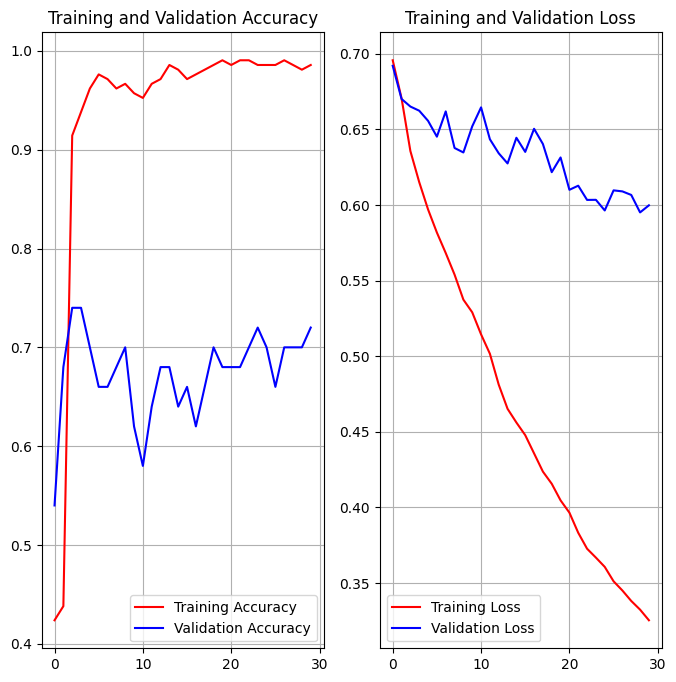

In [14]:
if(train_flag):
    epochs_range = range(epochs)
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history['train_accuracy'], label='Training Accuracy', color='red')
    plt.plot(epochs_range, history['val_accuracy'], label='Validation Accuracy', color='blue')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history['train_loss'], label='Training Loss', color='red')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', color='blue')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss')
    plt.grid()
    plt.show()


In [15]:
tloss, tacc = test_loop(df_test, model, loss_fn, history, 2)
print("test loss and accuracy: ", tloss, tacc)
for i in range (num_classes):
    print("test loss and accuracy on target ", i, ": ", history['test_loss'][i][0], history['test_accuracy'][i][0])

test loss and accuracy:  0.29329889386892316 0.7431561996779388
test loss and accuracy on target  0 :  0.35015456318855287 0.7037037037037037
test loss and accuracy on target  1 :  0.2364432245492935 0.782608695652174


In [16]:
if(train_flag):
    torch.save(model.state_dict(), 'param3_q_15.pth')